In [1]:
from collections import defaultdict
import numpy as np
import pdb
import dill
import random
from itertools import combinations, product
import matplotlib.pyplot as plt
from math import sqrt
import pandas as pd
from sklearn.metrics import f1_score, confusion_matrix, silhouette_score, davies_bouldin_score

In [31]:
class Lorentz:
    def __init__(self, s = 10, r = 28, b = 8/3):
        self.s = s
        self.r = r
        self.b = b

    def X(self, x, y, s):
        return s * (y - x)

    def Y(self, x, y, z, r):
        return (-x) * z + r * x - y

    def Z(self, x, y, z, b):
        return x * y - b * z

    def RK4(self, x, y, z, s, r, b, dt):
        k_1 = self.X(x, y, s)
        l_1 = self.Y(x, y, z, r)
        m_1 = self.Z(x, y, z, b)

        k_2 = self.X((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), s)
        l_2 = self.Y((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), r)
        m_2 = self.Z((x + k_1 * dt * 0.5), (y + l_1 * dt * 0.5), (z + m_1 * dt * 0.5), b)

        k_3 = self.X((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), s)
        l_3 = self.Y((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), r)
        m_3 = self.Z((x + k_2 * dt * 0.5), (y + l_2 * dt * 0.5), (z + m_2 * dt * 0.5), b)

        k_4 = self.X((x + k_3 * dt), (y + l_3 * dt), s)
        l_4 = self.Y((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), r)
        m_4 = self.Z((x + k_3 * dt), (y + l_3 * dt), (z + m_3 * dt), b)

        x += (k_1 + 2 * k_2 + 2 * k_3 + k_4) * dt * (1/6)
        y += (l_1 + 2 * l_2 + 2 * l_3 + l_4) * dt * (1/6)
        z += (m_1 + 2 * m_2 + 2 * m_3 + m_4) * dt * (1/6)

        return (x, y, z)

    def generate(self, dt, steps):
        x_0, y_0, z_0 = 1, 1, 1

        x_list = [x_0]
        y_list = [y_0]
        z_list = [z_0]

        i = 0

        while i < steps:
            x = x_list[i]
            y = y_list[i]
            z = z_list[i]

            position = self.RK4(x, y, z, self.s, self.r, self.b, dt)

            x_list.append(position[0])
            y_list.append(position[1])
            z_list.append(position[2])

            i += 1

        x_array = np.array(x_list)
        y_array = np.array(y_list)
        z_array = np.array(z_list)

        return x_array, y_array, z_array

In [32]:
xs, _, _ = Lorentz().generate(0.1, 11299)
xs = (xs - xs.min()) / (xs.max() - xs.min())

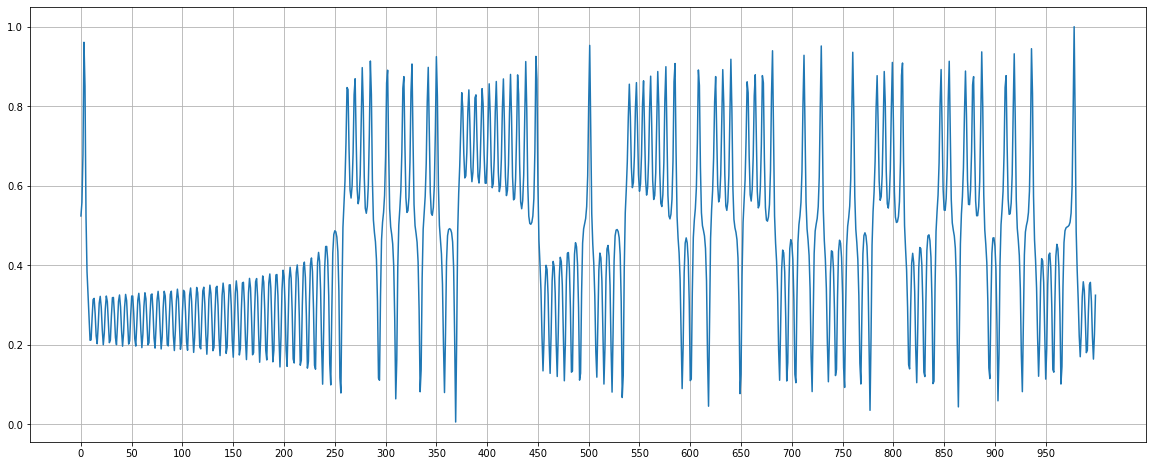

In [33]:
plt.figure(figsize=(20, 8))
plt.plot(xs[:1000])
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()

In [34]:
list_for_delete = []
for i in range(300):
    list_for_delete.append(i)

xs = np.delete(xs, list_for_delete)

xs_train = np.split(xs, [10000])[0]
xs_test = np.split(xs, [10000])[1]

In [35]:
pat_ua = []
for i in range(len(xs_train)):
    pat_ua.append([0,0,0])

pat_ua[0][0] = xs_train[0]
pat_ua[0][1] = xs_train[1]
pat_ua[1][0] = xs_train[1]
for i in range(2, len(xs_train)):
    pat_ua[i-2][2] = xs_train[i]
    pat_ua[i-1][1] = xs_train[i]
    pat_ua[i][0] = xs_train[i]

pat_ua.pop()
pat_ua.pop()

[0.7010456161462454, 0.5772523385465035, 0]

In [36]:
epsilon = 0.05

# гребінецi

In [37]:
# тут чекаем расческу подходит или нет
# у расчестки (гребінець) выткнут первый
def predict_ua1(shablon, epsilon, x2, x3):
    if abs(shablon[1] - x2) < epsilon and abs(shablon[2] - x3) < epsilon:
        return shablon[0]
    return False

# у расчестки выткнут второй
def predict_ua2(shablon, epsilon, x1, x3):
    if abs(shablon[0] - x1) < epsilon and abs(shablon[2] - x3) < epsilon:
        return shablon[1]
    return False

# у расчестки выткнут третий
def predict_ua3(shablon, epsilon, x1, x2):
    if abs(shablon[0] - x1) < epsilon and abs(shablon[1] - x2) < epsilon:
        return shablon[2]
    return False

In [48]:
i = 0
massiv_prognoz = []
for x in xs_test:
    x_possible = []
    x_new = 0
    # типа первый элемент
    if i == 0:
        for j in pat_ua:
            pos = predict_ua1(j, epsilon, xs_test[i + 1], xs_test[i + 2])
            if pos != False:
                x_possible.append(pos)
        x_new = sum(x_possible) / len(x_possible)
    # типа второй элемент
    elif i == 1:
        for j in pat_ua:
            pos = predict_ua1(j, epsilon, xs_test[i + 1], xs_test[i + 2])
            if pos != False:
                x_possible.append(pos)
        for j in pat_ua:
            pos = predict_ua2(j, epsilon, xs_test[i - 1], xs_test[i + 1])
            if pos != False:
                x_possible.append(pos)
        x_new = sum(x_possible) / len(x_possible)
    
    # предпоследний
    elif i == len(xs_test) - 2:
        for j in pat_ua:
            pos = predict_ua2(j, epsilon, xs_test[i - 1], xs_test[i + 1])
            if pos != False:
                x_possible.append(pos)
        for j in pat_ua:
            pos = predict_ua3(j, epsilon, xs_test[i - 2], xs_test[i - 1])
            if pos != False:
                x_possible.append(pos)
        x_new = sum(x_possible) / len(x_possible)
    
    # последний элемент
    elif i == len(xs_test) - 1:
        for j in pat_ua:
            pos = predict_ua3(j, epsilon, xs_test[i - 2], xs_test[i - 1])
            if pos != False:
                x_possible.append(pos)
        x_new = sum(x_possible) / len(x_possible)
    
    # все остальные
    else:
        for j in pat_ua:
            pos = predict_ua1(j, epsilon, xs_test[i + 1], xs_test[i + 2])
            if pos != False:
                x_possible.append(pos)
        for j in pat_ua:
            pos = predict_ua2(j, epsilon, xs_test[i - 1], xs_test[i + 1])
            if pos != False:
                x_possible.append(pos)
        for j in pat_ua:
            pos = predict_ua3(j, epsilon, xs_test[i - 2], xs_test[i - 1])
            if pos != False:
                x_possible.append(pos)
        x_new = sum(x_possible) / len(x_possible)
    if len(x_possible) == 0:
        x_new = x
    massiv_prognoz.append(x_new)
    i += 1

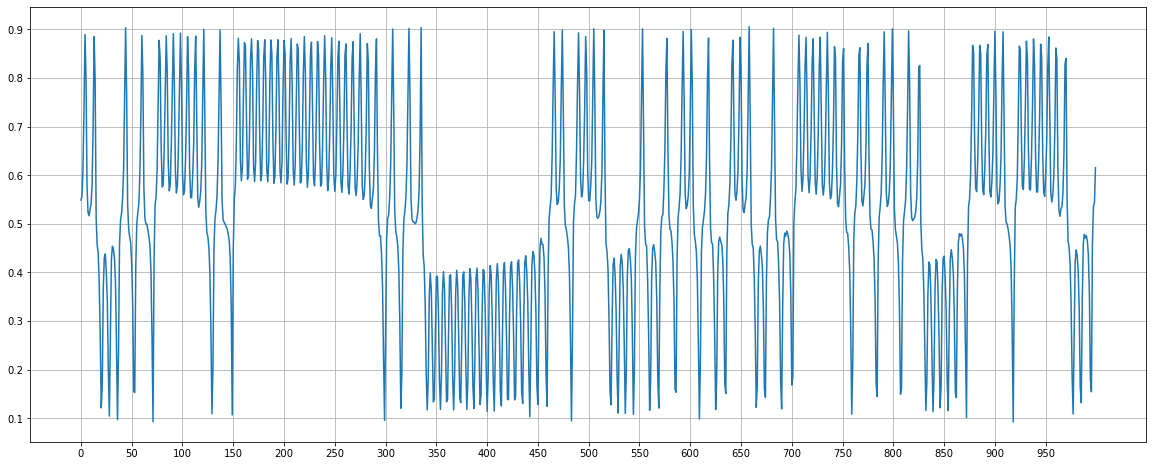

In [49]:
plt.figure(figsize=(20, 8))
plt.plot(massiv_prognoz)
plt.xticks([i for i in range(0, 1000, 50)])
plt.grid()
plt.show()